# Mnist 手寫數字辨識

大綱:

    1.定義問題

    2.資料的蒐集和探勘

    3.選擇及建立模型

    4.參數的設置和調整

    5.解果呈現

# 1.定義問題:

    先弄清楚這個問題目標是什麼，我們想辨識0~9的數字，也就是將Data分成0~9十種Lable，所以這是一個分類問題。

# 2.資料的蒐集和探勘:

    依照Kaggle給予的csv資料來做分析。

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [109]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.1查看資料是否平衡

簡單的列出資料看一下內容，可以把整個csv分成x_train(pixel0~pixel783)與y_train(label)。

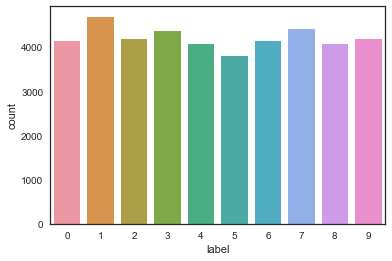

In [110]:
y_train = train["label"]

x_train = train.drop(labels = ["label"],axis = 1) #把label欄位丟掉

del train #節省空間已經拆成xtrain ytrain了，train用不到了

g = sns.countplot(y_train) #列出y_train長條圖

為何要列出label來看，這是為了要看大家的資料筆數有沒有很大的差距，如果有些資料太少就要用一些方法來調整，當然這邊是不需要這麼做的。

這邊放個遇到資料不平均時該怎麼處理~~

<a href="https://blog.csdn.net/heyongluoyao8/article/details/49408131">在分类中如何处理训练集中不平衡问题</a>

## 2.2資料中有無空值

In [111]:
x_train.isnull().any().describe() #看有無缺失值

count       784
unique        1
top       False
freq        784
dtype: object

In [112]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## 2.3 Normalization

    為何要做資料了標準化? 因為接下來我將採用KERAS來建捲積神經網路(convolutional neural network)來當模型
    
    而在CNN中0~1的小數可以收斂的更快

In [113]:
x_train = x_train / 255.0
test = test / 255.0

## 2.4 Reshape

     從csv中讀出來的每個數字都是784*1的一維矩陣，所以我們要將他reshape回28*28*1(灰階)的三維矩陣。

In [114]:
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## 2.5 Label encoding

    將0~9的分類也轉成一個向量。例:5 = [0,0,0,0,0,1,0,0,0,0,]

In [115]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes = 10)

## 2.6 Split training and valdiation set 

    將60000個train data分成42000個訓練集跟6000個驗證集，並用random_seed來做作隨機分割。

In [116]:
from sklearn.model_selection import train_test_split #將訓練及分出一部份來當驗證集



sns.set(style='white', context='notebook', palette='deep')

random_seed = 2

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

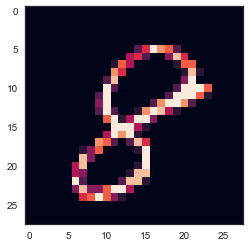

In [117]:
g = plt.imshow(x_train[0][:,:,0])

# 3. 選擇及建立模型

## 3.1 CNN

<a href="https://medium.com/@syshen/%E5%85%A5%E9%96%80%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-2-d694cad7d1e5">關於CNN</a>

    這裡使用

In [118]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 64)          0         
__________

## 3.2 設優化器並編譯模型

In [119]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [120]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# 4 參數的設置和調整

## 4.1學習速率

    Learning rate高雖然收斂速度快，但可能掉進局部最小值，並非在全局最小值。
    
    在這邊我參考kernel一位作者參數。patience=3 (3輪沒提升LR減半) factor=0.5(減半)
    
<img src="http://img1.imagilive.com/0717/learningrates.jpg"> </img>

In [121]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 5 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

## 4.2 數據增強擴增

<a href="https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6">參考kernel</a>

In [122]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 4.3Modle fit
    將資料餵入開始訓練!!

In [123]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/5
 - 291s - loss: 0.4183 - acc: 0.8663 - val_loss: 0.0622 - val_acc: 0.9798
Epoch 2/5
 - 292s - loss: 0.1318 - acc: 0.9596 - val_loss: 0.0445 - val_acc: 0.9831
Epoch 3/5
 - 295s - loss: 0.0988 - acc: 0.9702 - val_loss: 0.0441 - val_acc: 0.9874
Epoch 4/5
 - 299s - loss: 0.0846 - acc: 0.9748 - val_loss: 0.0461 - val_acc: 0.9860
Epoch 5/5
 - 309s - loss: 0.0734 - acc: 0.9777 - val_loss: 0.0238 - val_acc: 0.9936


## 4.4模型評估

#### 4.4.1觀察有無嚴重的overfitting

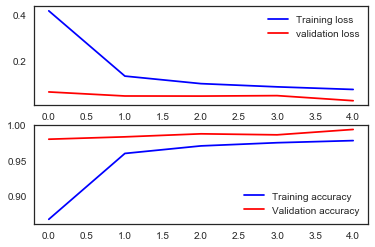

In [124]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#### 運用混淆矩陣觀察

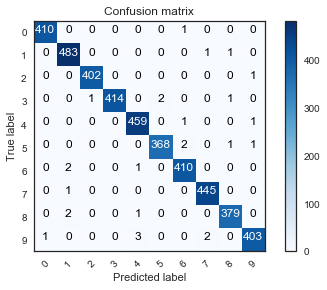

In [125]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

# 5.結果的呈現(依kaggle)


In [126]:
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("mnist.csv",index=False)